In [1]:
import torch
import numpy as np
from matplotlib import pyplot as plt
    
use64 = False
if use64:
    torch.set_default_dtype(torch.float64)

import src.models.flows.coupling_cells.piecewise_coupling.piecewise_linear as pwl

In [2]:
T = pwl.piecewise_linear_transform
iT = pwl.piecewise_linear_inverse_transform

In [3]:
def checkT_iT(N,k,b):
    x = torch.zeros((N,k)).uniform_()
    q = torch.zeros((N,k,b)).uniform_()
    
    y,j = T(x,q)
    ix,ij = iT(y,q)
    print(x)
    print(ix)
    print(torch.exp(j)*torch.exp(ij))
    return torch.abs(ix-x)/torch.abs(ix+x)

In [4]:
prop = checkT_iT(1000,1,5)
prop.squeeze_()
prop=prop.cpu().detach().numpy()

tensor([[2.8481e-01],
        [5.2999e-01],
        [1.0201e-01],
        [2.0229e-01],
        [5.0554e-01],
        [7.7146e-02],
        [4.1228e-01],
        [4.1952e-01],
        [3.5799e-01],
        [3.2374e-01],
        [7.2958e-01],
        [2.3227e-01],
        [6.0534e-03],
        [5.4263e-01],
        [1.5484e-01],
        [7.7217e-01],
        [6.9233e-01],
        [2.1635e-01],
        [4.6438e-01],
        [1.9763e-01],
        [3.2181e-01],
        [5.0167e-02],
        [4.7905e-01],
        [7.2804e-01],
        [6.1566e-01],
        [2.1569e-01],
        [7.5505e-01],
        [3.9814e-01],
        [6.5818e-01],
        [7.7210e-02],
        [9.5699e-01],
        [5.9299e-01],
        [2.2066e-02],
        [7.3104e-01],
        [2.2244e-01],
        [6.5633e-01],
        [9.8736e-01],
        [5.5458e-02],
        [6.7143e-01],
        [4.3859e-01],
        [8.7261e-01],
        [7.4498e-01],
        [9.3570e-01],
        [5.0930e-01],
        [9.0323e-01],
        [9

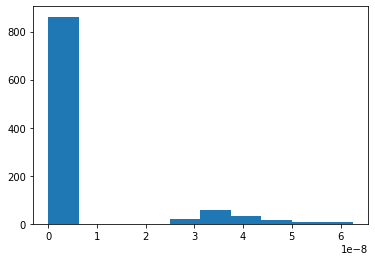

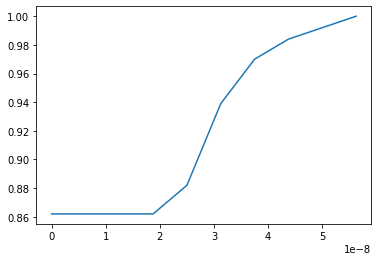

In [5]:
v,b,_ = plt.hist(prop)
plt.show()
plt.plot(b[:-1],np.cumsum(v)/1000.)

In [6]:
N=25
k=2
b=3
x = torch.zeros((N,k)).uniform_()
q = torch.zeros((N,k,b)).uniform_()

y,j = T(x,q)
ix,ij = iT(y,q)

In [7]:
(x-ix)/(x+ix)

tensor([[ 0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00],
        [ 3.2128e-08,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00],
        [ 0.0000e+00, -4.7797e-08],
        [ 0.0000e+00,  0.0000e+00],
        [ 0.0000e+00, -4.9823e-08],
        [ 0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00],
        [ 0.0000e+00, -3.0540e-08],
        [ 0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00],
        [-4.2158e-08,  0.0000e+00],
        [-3.7080e-08,  0.0000e+00],
        [-4.0012e-08,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00]])

In [8]:
j+ij

tensor([ 0.0000,  0.0000,  0.0000, -0.4125, -0.0865,  0.0000,  0.0000,  0.0000,
        -0.1760,  0.0000,  0.0000,  0.0000,  0.0680,  0.0000,  0.0000, -0.6015,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000])

In [31]:
third_dimension_softmax = torch.nn.Softmax(dim=2)

def piecewise_linear_transform(x, q_tilde, compute_jacobian=True):
    """Apply an element-wise piecewise-linear transformation to some variables

    Parameters
    ----------
    x : torch.Tensor
        a tensor with shape (N,k) where N is the batch dimension while k is the
        dimension of the variable space. This variable span the k-dimensional unit
        hypercube

    q_tilde: torch.Tensor
        is a tensor with shape (N,k,b) where b is the number of bins.
        This contains the un-normalized heights of the bins of the piecewise-constant PDF for dimension k,
        i.e. q_tilde lives in all of R and we don't impose a constraint on their sum yet.
        Normalization is imposed in this function using softmax.

    compute_jacobian : bool, optional
        determines whether the jacobian should be compute or None is returned

    Returns
    -------
    tuple of torch.Tensor
        pair `(y,h)`.
        - `y` is a tensor with shape (N,k) living in the k-dimensional unit hypercube
        - `j` is the jacobian of the transformation with shape (N,) if compute_jacobian==True, else None.
    """

    logj = None

    # TODO do a bottom-up assesment of how we handle the differentiability of variables

    # Compute the bin width w
    N, k, b = q_tilde.shape
    Nx, kx = x.shape
    assert N == Nx and k == kx, "Shape mismatch"

    w = 1. / b

    # Compute the normalized bin heights by applying a softmax function on the bin dimension
    q = 1. / w * third_dimension_softmax(q_tilde)

    # x is in the mx-th bin: x \in [0,1],
    # mx \in [[0,b-1]], so we clamp away the case x == 1
    mx = torch.clamp(torch.floor(b * x), 0, b - 1).to(torch.long)
    # We compute the output variable in-place
    out = x - mx * w  # alpha (element of [0.,w], the position of x in its bin

    # Multiply by the slope
    # q has shape (N,k,b), mxu = mx.unsqueeze(-1) has shape (N,k) with entries that are a b-index
    # gather defines slope[i, j, k] = q[i, j, mxu[i, j, k]] with k taking only 0 as a value
    # i.e. we say slope[i, j] = q[i, j, mx [i, j]]
    slopes = torch.gather(q, 2, mx.unsqueeze(-1)).squeeze(-1)
    out = out * slopes
    # The jacobian is the product of the slopes in all dimensions
    if compute_jacobian:
        logj = torch.log(torch.prod(slopes, 1))

    del slopes

    # Compute the integral over the left-bins.
    # 1. Compute all integrals: cumulative sum of bin height * bin weight.
    # We want that index i contains the cumsum *strictly to the left* so we shift by 1
    # leaving the first entry null, which is achieved with a roll and assignment
    q_left_integrals = torch.roll(torch.cumsum(q, 2) * w, 1, 2)
    q_left_integrals[:, :, 0] = 0

    # 2. Access the correct index to get the left integral of each point and add it to our transformation
    out = out + torch.gather(q_left_integrals, 2, mx.unsqueeze(-1)).squeeze(-1)

    # Regularization: points must be strictly within the unit hypercube
    # Use the dtype information from pytorch
    eps = torch.finfo(out.dtype).eps
    out = out.clamp(
        min=eps,
        max=1. - eps
    )

    return out, logj, mx


def piecewise_linear_inverse_transform(y, q_tilde, compute_jacobian=True):
    """
    Apply the inverse of an element-wise piecewise-linear transformation to some variables

    Parameters
    ----------
    y : torch.Tensor
        a tensor with shape (N,k) where N is the batch dimension while k is the
        dimension of the variable space. This variable span the k-dimensional unit
        hypercube

    q_tilde: torch.Tensor
        is a tensor with shape (N,k,b) where b is the number of bins.
        This contains the un-normalized heights of the bins of the piecewise-constant PDF for dimension k,
        i.e. q_tilde lives in all of R and we don't impose a constraint on their sum yet.
        Normalization is imposed in this function using softmax.

    compute_jacobian : bool, optional
        determines whether the jacobian should be compute or None is returned

    Returns
    -------
    tuple of torch.Tensor
        pair `(x,h)`.
        - `x` is a tensor with shape (N,k) living in the k-dimensional unit hypercube
        - `j` is the jacobian of the transformation with shape (N,) if compute_jacobian==True, else None.
    """

    # TODO do a bottom-up assesment of how we handle the differentiability of variables

    # Compute the bin width w
    N, k, b = q_tilde.shape
    Ny, ky = y.shape
    assert N == Ny and k == ky, "Shape mismatch"

    w = 1. / b

    # Compute the normalized bin heights by applying a softmax function on the bin dimension
    q = 1. / w * third_dimension_softmax(q_tilde)

    # Compute the integral over the left-bins in the forward transform.
    # 1. Compute all integrals: cumulative sum of bin height * bin weight.
    # We want that index i contains the cumsum *strictly to the left* so we shift by 1
    # leaving the first entry null, which is achieved with a roll and assignment
    q_left_integrals = torch.roll(torch.cumsum(q, 2) * w, 1, 2)
    q_left_integrals[:, :, 0] = 0

    # We can figure out which bin each y belongs to by finding the smallest bin such that
    # y - q_left_integral is positive

    edges = (y.unsqueeze(-1) - q_left_integrals).detach()
    # y and q_left_integrals are between 0 and 1 so that their difference is at most 1.
    # By setting the negative values to 2., we know that the smallest value left
    # is the smallest positive
    edges[edges <= 0] = 2.
    edges = torch.argmin(edges, dim=2)

    # Gather the left integrals at each edge. See comment about gathering in q_left_integrals
    # for the unsqueeze
    q_left_integrals = q_left_integrals.gather(2, edges.unsqueeze(-1)).squeeze(-1)

    # Gather the slope at each edge.
    q = q.gather(2, edges.unsqueeze(-1)).squeeze(-1)

    # Build the output
    x = (y - q_left_integrals) / q + edges * w

    # Regularization: points must be strictly within the unit hypercube
    # Use the dtype information from pytorch
    eps = torch.finfo(x.dtype).eps
    x = x.clamp(
        min=eps,
        max=1. - eps
    )

    # Prepare the jacobian
    logj = None
    if compute_jacobian:
        logj = - torch.log(torch.prod(q, 1))
    return x.detach(), logj, edges



In [32]:
b = 100
N=100000
k=1

w = 1. / b

x = torch.zeros(N,k).uniform_()
q_tilde = torch.zeros(N,k,b).normal_()

In [33]:
y,j,mx = piecewise_linear_transform(x,q_tilde)
ix,ij,imx = piecewise_linear_inverse_transform(y,q_tilde)

(array([     0.,      0.,      0.,      0.,      0., 100000.,      0.,
             0.,      0.,      0.]),
 array([-0.5, -0.4, -0.3, -0.2, -0.1,  0. ,  0.1,  0.2,  0.3,  0.4,  0.5]),
 <a list of 10 Patch objects>)

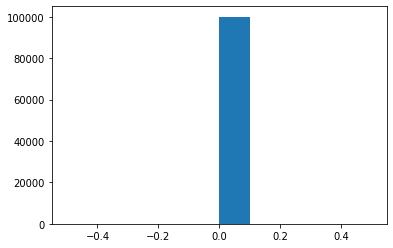

In [34]:
plt.hist((mx - imx).numpy().flatten())

In [14]:
q = 1. / w * third_dimension_softmax(q_tilde)

In [15]:
mx = torch.clamp(torch.floor(b * x), 0, b - 1).to(torch.long)

In [16]:
mx,x

(tensor([[1, 2],
         [0, 0]]),
 tensor([[0.5008, 0.7156],
         [0.2166, 0.0126]]))

In [17]:
out = x - mx * w 
out

tensor([[0.1674, 0.0489],
        [0.2166, 0.0126]])

In [18]:
x - out

tensor([[0.3333, 0.6667],
        [0.0000, 0.0000]])

In [19]:
out = x - mx * w 

In [20]:
slopes = torch.gather(q, 2, mx.unsqueeze(-1)).squeeze(-1)

In [21]:
q*w

tensor([[[0.3746, 0.2631, 0.3623],
         [0.0822, 0.4163, 0.5015]],

        [[0.4901, 0.0665, 0.4435],
         [0.6332, 0.1476, 0.2192]]])

In [22]:
slopes

tensor([[0.7892, 1.5044],
        [1.4702, 1.8995]])

In [23]:
out = out*slopes

In [24]:
q_left_integrals = torch.roll(torch.cumsum(q, 2) * w, 1, 2)
q_left_integrals[:, :, 0] = 0
q_left_integrals

tensor([[[0.0000, 0.3746, 0.6377],
         [0.0000, 0.0822, 0.4985]],

        [[0.0000, 0.4901, 0.5565],
         [0.0000, 0.6332, 0.7808]]])

In [25]:
torch.gather(q_left_integrals, 2, mx.unsqueeze(-1)).squeeze(-1)

tensor([[0.3746, 0.4985],
        [0.0000, 0.0000]])

In [27]:
out = out + torch.gather(q_left_integrals, 2, mx.unsqueeze(-1)).squeeze(-1)

out

tensor([[0.5067, 0.5721],
        [0.3185, 0.0239]])